In [1]:
import pandas as pd
import requests

# Don't forget to 'pip install fastf1'
import fastf1 as ff1
from fastf1 import plotting

# Don't forget to 'pip install seaborn'
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()
    
    return response['MRData']

In [3]:
# By changing these params you can easily get other seasons 
season = 2021
drivers_to_exclude = ['KUB']

In [4]:
all_quali_results = pd.DataFrame()

# We want this so that we know which driver belongs to which team, so we can color them later
team_drivers = {}

current_round = 1

while True:
    race = ergast_retrieve(f'{season}/{current_round}/qualifying')
    
    # If session doesn't exist, cancel loop
    if not race['RaceTable']['Races']:
        break

    results = race['RaceTable']['Races'][0]['QualifyingResults']

    quali_results = {'round': current_round}

    for j in range(len(results)):
        driver = results[j]['Driver']['code']
        position = int(results[j]['position'])
        team = results[j]['Constructor']['name']
        
        if driver in drivers_to_exclude:
            continue
        
        # Create mapping for driver - team
        if not team in team_drivers:
            team_drivers[team] = [driver]
        else:
            if not driver in team_drivers[team]:
                team_drivers[team].append(driver)
                
        quali_results[driver] = position
            
    all_quali_results = all_quali_results.append(quali_results, ignore_index=True)
    
    current_round += 1

In [5]:
# Now we want to know, per round, per team, who qualified higher?
all_quali_battle_results = []
team_colors_palette = []

for team in team_drivers:
    drivers = team_drivers[team]
    
    quali_results = all_quali_results[drivers]
    
    # We do dropna() to only include the sessions in which both drivers participated
    fastest_driver_per_round = quali_results.dropna().idxmin(axis=1)
    
    quali_battle_result = fastest_driver_per_round.value_counts().reset_index()
    
    for _, driver in quali_battle_result.iterrows():
        all_quali_battle_results.append({
            'driver': driver['index'],
            'team': team,
            'quali_score': driver[0]
        })
    
    team_colors_palette.append(ff1.plotting.team_color(team))
    # If none, replace None with grey
    team_colors_palette = ['#D3D3D3' if v is None else v for v in team_colors_palette]


# Finally, convert to a DataFrame so we can plot
all_quali_battle_results = pd.DataFrame.from_dict(all_quali_battle_results)

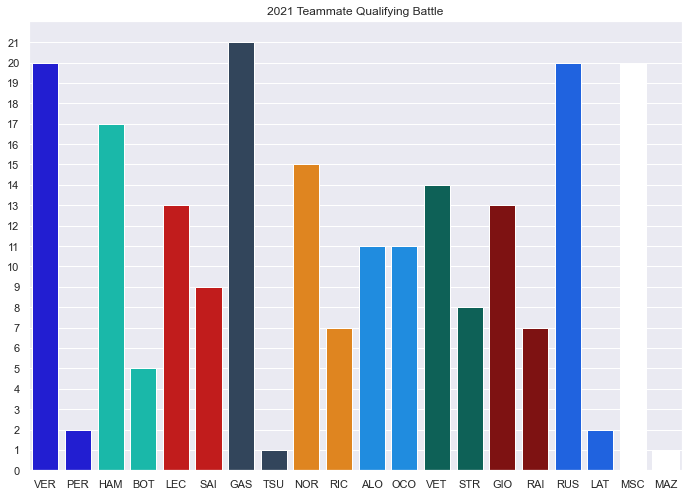

In [6]:
# Increase the size of the plot 
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create custom color palette
custom_palette = sns.set_palette(sns.color_palette(team_colors_palette))

fig, ax = plt.subplots()

ax.set_title(f"{season} Teammate Qualifying Battle")

g = sns.barplot(
    x='driver',
    y='quali_score', 
    hue='team',
    data=all_quali_battle_results, 
    dodge=False,
    palette=custom_palette,
)

plt.yticks(range(max(all_quali_battle_results['quali_score']) + 1))

plt.legend([],[], frameon=False)

g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('img/qualifying_battles.png')

plt.show()